In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,  roc_auc_score, make_scorer, average_precision_score
from sklearn.utils import resample


from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve  
from sklearn.metrics import roc_curve, auc
from scipy.optimize import curve_fit


from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer

In [3]:
date_limit = '2024-09-01'

df = pd.read_excel('pricing_logs_history_722984.xlsx', sheet_name='Data')
occupancy_df = pd.read_excel('pricing_logs_history_722984.xlsx', sheet_name='Occupancy')

# Import and merge
df = df.merge(occupancy_df[['Date','Occupancy']], on='Date').drop_duplicates()

# Calculate Lead Time
df['Lead Time'] = df['Date'] - df['As of Date']
df['Lead Time'] = df['Lead Time'].dt.days

# Convert Occupancy to a decimal
df['Occupancy'] = df['Occupancy'] / 100

# Sort Dataframe
df.sort_values(by=['As of Date','Date'], ascending=[True,True], inplace=True)
df = df.reset_index(drop=True)

# Create a date_id column for the df dataframe that combines the Booking Date and the Stay Date
df['date_id'] = df['As of Date'].astype('str') + '_' + df['Date'].astype('str') 

# Add Booked Binary Column
df['Booked'] = df.apply(lambda x: 1 if x['Booked_Price'] > 0 else 0, axis=1)

# Drop the Booked Price column
if 'Booked_Price' in df.columns:
    df.drop(columns=['Booked_Price'], inplace=True)

# Limit dataframe to dates less than the date limit
df = df[df['Date'] <= date_limit]

# Limit the data to only observations within 180 day lead time
df = df[(df['Lead Time'] <= 180) & (df['Lead Time'] >= 0)]

# Create a dataframe that is limited to days that were booked
booked_df = df[df['Booked'] == 1]

# Create a booked_dates dataframe that only contains days that a booking occured
booked_dates = booked_df[['Date','As of Date']].groupby(by='Date').min().reset_index(drop=False).rename(columns={'As of Date':'Booking Date'})

# Create a date_id column bor the booked_dates dataframe that combines the Booking Date and the Stay Date
booked_dates['date_id'] = booked_dates['Booking Date'].astype('str') + '_' + booked_dates['Date'].astype('str') 

# Merge the price data as of the Booking Date and name column 'Booked Price'
booked_dates = booked_dates.merge(df[['date_id','Price']], on='date_id').rename(columns={'Price':'Booked Price'})

# Add the Booked price column to the main dataframe (df)
df = df.merge(booked_dates[['Date', 'Booking Date', 'Booked Price']], on='Date', how='left')

# Create a new column called 'Modeled Price' that uses the daily price for all days leading up to booking date, 
# then Booked Price for all dates on or after the booking date
df['Modeled_Price'] = df.apply(lambda x: x['Booked Price'] if x['Booked'] == 1 else x['Price'], axis=1)

df_model = df[['Modeled_Price', 'Occupancy','Lead Time', 'Booked']].copy()



In [5]:
df = df.sort_values(by=['Date','As of Date'], ascending=[True, True]).reset_index(drop=True)

df['Price_lag7'] = df.groupby('Date')['Modeled_Price'].shift(7)
df['Price_7day_avg'] = df.groupby('Date')['Modeled_Price'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df['Price_slope7'] = df['Modeled_Price'] - df['Price_7day_avg']

df = df.dropna(subset=['Price_lag7'])


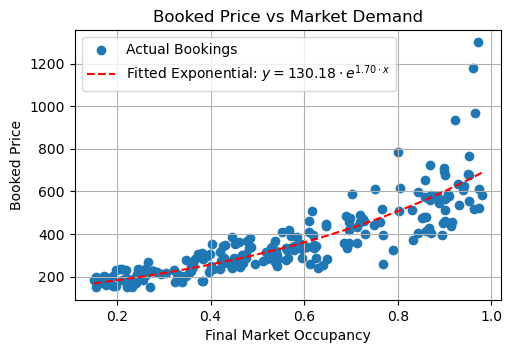

In [7]:
booking_day_df = df[df['Booking Date'] == df['As of Date']].sort_values(by='Occupancy').reset_index(drop=True)
booked_market_occupancies = booking_day_df['Occupancy']
booked_prices = booking_day_df['Booked Price']

unbooked_days_df = df[df['Booked'] == 0].reset_index(drop=True)

# Define the exponential function
def exponential_model(x, a, b):
    return a * np.exp(b * x)

# Fit the exponential model to the data
params, covariance = curve_fit(exponential_model, booked_market_occupancies, booked_prices, p0=(1, 0.1))

# Extract the fitted parameters
a, b = params

# Generate fitted values
fitted_y = exponential_model(booked_market_occupancies, a, b)

plt.figure(figsize=(5.5, 3.5))
plt.scatter(booked_market_occupancies, booked_prices, label='Actual Bookings')
plt.plot(booked_market_occupancies, fitted_y, label=f'Fitted Exponential: $y = {a:.2f} \cdot e^{{{b:.2f} \cdot x}}$', color='red', linestyle='--')
plt.xlabel('Final Market Occupancy')
plt.ylabel('Booked Price')
plt.title('Booked Price vs Market Demand')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
booking_day_df.head()

,As of Date,Date,Price,Occupancy,Lead Time,date_id,Booked,Booking Date,Booked Price,Modeled_Price,Price_lag7,Price_7day_avg,Price_slope7
0,2024-07-13,2024-08-13,183,0.151,31,2024-07-13_2024-08-13,1,2024-07-13,183.0,183.0,201.0,188.285714,-5.285714
1,2024-04-06,2024-04-30,197,0.156,24,2024-04-06_2024-04-30,1,2024-04-06,197.0,197.0,187.0,199.571429,-2.571429
2,2024-02-15,2024-02-28,152,0.156,13,2024-02-15_2024-02-28,1,2024-02-15,152.0,152.0,155.0,155.142857,-3.142857
3,2024-08-09,2024-08-28,167,0.158,19,2024-08-09_2024-08-28,1,2024-08-09,167.0,167.0,166.0,166.142857,0.857143
4,2024-03-06,2024-03-06,169,0.159,0,2024-03-06_2024-03-06,1,2024-03-06,169.0,169.0,257.0,205.142857,-36.142857


In [9]:

unbooked_days_df.head()

,As of Date,Date,Price,Occupancy,Lead Time,date_id,Booked,Booking Date,Booked Price,Modeled_Price,Price_lag7,Price_7day_avg,Price_slope7
0,2023-09-11,2023-09-13,222,0.189,2,2023-09-11_2023-09-13,0,NaT,NaN,222.0,179.0,212.000000,10.000000
1,2023-09-12,2023-09-13,220,0.189,1,2023-09-12_2023-09-13,0,NaT,NaN,220.0,180.0,217.714286,2.285714
2,2023-09-13,2023-09-13,217,0.189,0,2023-09-13_2023-09-13,0,NaT,NaN,217.0,180.0,223.000000,-6.000000
3,2023-09-11,2023-09-14,239,0.278,3,2023-09-11_2023-09-14,0,NaT,NaN,239.0,195.0,224.571429,14.428571
4,2023-09-12,2023-09-14,239,0.278,2,2023-09-12_2023-09-14,0,NaT,NaN,239.0,193.0,231.142857,7.857143


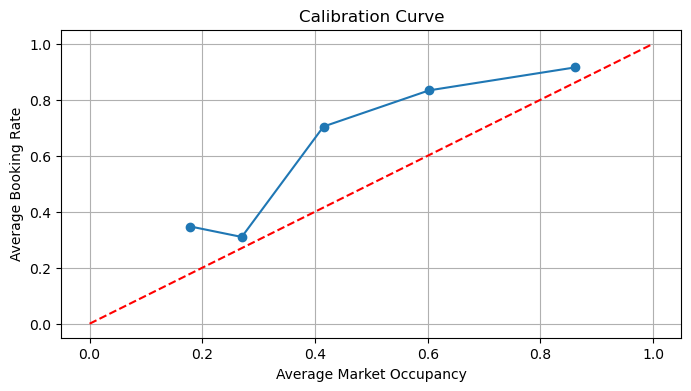

In [11]:
last_day_df = df[df['Lead Time'] == 0].copy()

# Bin the market occupancy values
n_bins = 5  
last_day_df['occupancy_bin'] = pd.qcut(last_day_df['Occupancy'], q=n_bins, labels=False)

# Calculate average booking rate and average market occupancy per bin
bin_summary = last_day_df.groupby('occupancy_bin').agg({
    'Booked': 'mean',  # Average booking rate in each bin
    'Occupancy': 'mean'  # Average market occupancy in each bin
}).reset_index()

# Plot calibration curve that shows the booking rate for this cabin compared to the average market occupancy
plt.figure(figsize=(8, 4))
plt.plot(bin_summary['Occupancy'], bin_summary['Booked'], marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
plt.xlabel('Average Market Occupancy')
plt.ylabel('Average Booking Rate')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [13]:

# Set the sample size
n = 2500  # or any other reasonable sample size

# Bootstrap sampling from each class
bootstrapped_booked = resample(booking_day_df, replace=True, n_samples=n, random_state=12)
bootstrapped_unbooked = resample(unbooked_days_df, replace=True, n_samples=n, random_state=12)

# Combine into a single balanced dataset
bootstrapped_df = pd.concat([bootstrapped_booked, bootstrapped_unbooked])



features = [
    # 'Modeled_Price', 
    'Occupancy',
    'Lead Time',
            'Price_7day_avg',   
            #  'Price_slope14'
            ]
target = ['Booked']

df_model = bootstrapped_df[['Date'] + features + target].copy()


unique_dates = df_model['Date'].unique()

# Split unique dates into training and test sets
train_dates, test_dates = train_test_split(unique_dates, test_size=0.10, random_state=10)

# Assign each row to train or test based on the date
df_train = df_model[df_model['Date'].isin(train_dates)]
df_test = df_model[df_model['Date'].isin(test_dates)]

# Define features and target for train and test sets

X = df_model[features]
y = df_model[target]


X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

In [15]:
# # Create a logistic regression model
model_log = LogisticRegression()

# Train the model on the entire dataset
model_log.fit(X_train, y_train.values.ravel())

# Make predictions on the same dataset
predictions_log_test = model_log.predict(X_test)
predictions_log_train = model_log.predict(X_train)

proba_log_train = model_log.predict_proba(X_train)[:, 1]
proba_log_test = model_log.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_log_test = accuracy_score(y_test.values.ravel(), predictions_log_test)
accuracy_log_train = accuracy_score(y_train.values.ravel(), predictions_log_train)

precision_log_train = average_precision_score(y_train.values.ravel(), proba_log_train)
precision_log_test = average_precision_score(y_test.values.ravel(), proba_log_test)

roc_auc_log_train = roc_auc_score(y_train.values.ravel(), proba_log_train)
roc_auc_log_test = roc_auc_score(y_test.values.ravel(), proba_log_test)

print(f'Train Accuracy: {accuracy_log_train:0.4f}')
print(f'Test Accuracy: {accuracy_log_test:0.4f}\n')
print(f'Train ROC AUC: {roc_auc_log_train:0.4f}')
print(f'Test ROC AUC: {roc_auc_log_test:0.4f}\n')
print(f'Train Precision Recall AUC: {precision_log_train:0.4f}')
print(f'Test Precision Recall AUC: {precision_log_test:0.4f}\n')

# Print coefficients with feature names
coefficients = model_log.coef_[0]  # Assuming binary classification (only one set of coefficients)
features = X_train.columns         # Get feature names

# Create a DataFrame for a clean display
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
coef_df

Train Accuracy: 0.7853
Test Accuracy: 0.7709

Train ROC AUC: 0.8660
Test ROC AUC: 0.8955

Train Precision Recall AUC: 0.8415
Test Precision Recall AUC: 0.8905



,Feature,Coefficient
0,Occupancy,5.917203
1,Lead Time,-0.027073
2,Price_7day_avg,-0.006236


In [17]:
from pygam import LogisticGAM, s
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
import pandas as pd

# Adjust the number of terms based on the number of features in X_train
gam = LogisticGAM(s(0) + s(1) + s(2))  # Replace with the correct number of features
gam.fit(X_train, y_train.values.ravel())

# Make predictions on the test and train datasets
predictions_gam_test = gam.predict(X_test)
predictions_gam_train = gam.predict(X_train)

# Predict probabilities for ROC AUC and precision-recall evaluation
proba_gam_train = gam.predict_proba(X_train)
proba_gam_test = gam.predict_proba(X_test)

# Evaluate the GAM model
accuracy_gam_test = accuracy_score(y_test.values.ravel(), predictions_gam_test)
accuracy_gam_train = accuracy_score(y_train.values.ravel(), predictions_gam_train)

precision_gam_train = average_precision_score(y_train.values.ravel(), proba_gam_train)
precision_gam_test = average_precision_score(y_test.values.ravel(), proba_gam_test)

roc_auc_gam_train = roc_auc_score(y_train.values.ravel(), proba_gam_train)
roc_auc_gam_test = roc_auc_score(y_test.values.ravel(), proba_gam_test)

print(f'Train Accuracy: {accuracy_gam_train:0.4f}')
print(f'Test Accuracy: {accuracy_gam_test:0.4f}\n')
print(f'Train ROC AUC: {roc_auc_gam_train:0.4f}')
print(f'Test ROC AUC: {roc_auc_gam_test:0.4f}\n')
print(f'Train Precision Recall AUC: {precision_gam_train:0.4f}')
print(f'Test Precision Recall AUC: {precision_gam_test:0.4f}\n')

# Summarize feature contributions
feature_importance = gam.statistics_['p_values']  # P-values for each smooth term
smoothing_coeffs = gam.coef_

# Retrieve feature-level contributions
features = X_train.columns  # Feature names
summary_data = []

for i, feature in enumerate(features):
    # Get the p-value and overall significance of the smooth term
    p_value = gam.statistics_['p_values'][i]
    
    # Extract the coefficients for the specific smooth term
    smooth_term_coefficients = gam.partial_dependence(term=i)
    
    # Calculate the mean magnitude of coefficients for interpretability
    mean_coefficient = smooth_term_coefficients.mean()
    
    # Append results to the summary data
    summary_data.append({'Feature': feature, 'Mean Coefficient': mean_coefficient, 'P-Value': p_value})

# Create a DataFrame for a clean summary
gam_summary = pd.DataFrame(summary_data)
print(gam_summary)


Train Accuracy: 0.8302
Test Accuracy: 0.7728

Train ROC AUC: 0.9015
Test ROC AUC: 0.8915

Train Precision Recall AUC: 0.8607
Test Precision Recall AUC: 0.8838

          Feature  Mean Coefficient  P-Value
0       Occupancy          0.035602      0.0
1       Lead Time          0.376358      0.0
2  Price_7day_avg         -0.346789      0.0


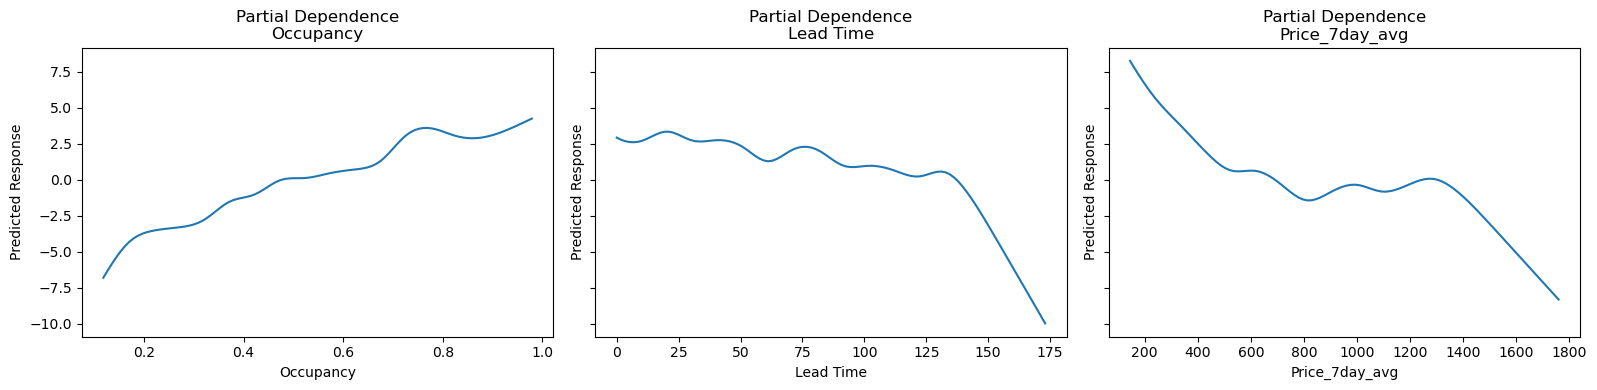

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Plot partial dependence for each feature
features = X_train.columns  # Get feature names

fig, axes = plt.subplots(1, len(features), figsize=(16, 4), sharey=True)  # Create subplots
for i, feature in enumerate(features):
    # Compute partial dependence for the i-th feature
    xx = gam.generate_X_grid(term=i)  # Generate grid for feature i
    part_d = gam.partial_dependence(term=i, X=xx)  # Get partial dependence values
    
    # Plot the partial dependence curve
    axes[i].plot(xx[:, i], part_d, label=f'{feature}')  # Plot the feature-specific curve
    axes[i].set_title(f'Partial Dependence\n{feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Predicted Response')

plt.tight_layout()
plt.show()


In [19]:
# # Create a logistic regression model
model_NB = GaussianNB()

# Train the model on the entire dataset
model_NB.fit(X_train, y_train.values.ravel())

# Make predictions on the same dataset
predictions_NB_test = model_NB.predict(X_test)
predictions_NB_train = model_NB.predict(X_train)

proba_NB_train = model_NB.predict_proba(X_train)[:, 1]
proba_NB_test = model_NB.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_NB_test = accuracy_score(y_test.values.ravel(), predictions_NB_test)
accuracy_NB_train = accuracy_score(y_train.values.ravel(), predictions_NB_train)

precision_NB_train = average_precision_score(y_train.values.ravel(), proba_NB_train)
precision_NB_test = average_precision_score(y_test.values.ravel(), proba_NB_test)

roc_auc_NB_train = roc_auc_score(y_train.values.ravel(), proba_NB_train)
roc_auc_NB_test = roc_auc_score(y_test.values.ravel(), proba_NB_test)

print(f'Train Accuracy: {accuracy_NB_train:0.4f}')
print(f'Test Accuracy: {accuracy_NB_test:0.4f}\n')
print(f'Train ROC AUC: {roc_auc_NB_train:0.4f}')
print(f'Test ROC AUC: {roc_auc_NB_test:0.4f}\n')
print(f'Train Precision Recall AUC: {precision_NB_train:0.4f}')
print(f'Test Precision Recall AUC: {precision_NB_test:0.4f}\n')

# # Print coefficients with feature names
# coefficients = model_log.coef_[0]  # Assuming binary classification (only one set of coefficients)
# features = X_train.columns         # Get feature names

Train Accuracy: 0.7336
Test Accuracy: 0.7374

Train ROC AUC: 0.8342
Test ROC AUC: 0.8737

Train Precision Recall AUC: 0.8194
Test Precision Recall AUC: 0.8724



In [20]:
# X_train# Initialize the SVM classifier with probability=True
# model_svm = SVC(probability=True, random_state=12, C=1, kernel='linear', gamma='scale')


# model_svm.fit(X_train, y_train.values.ravel())

# y_train_pred_svm = model_svm.predict(X_train)
# y_train_proba_svm = model_svm.predict_proba(X_train)[:, 1]

# # Calculate and print test set accuracy and ROC AUC for SVM
# train_accuracy_svm = accuracy_score(y_train.values.ravel(), y_train_pred_svm)
# train_roc_auc_svm = roc_auc_score(y_train.values.ravel(), y_train_proba_svm)
# train_pr_auc_svm = average_precision_score(y_train.values.ravel(), y_train_proba_svm)


# y_test_pred_svm = model_svm.predict(X_test)
# y_test_proba_svm = model_svm.predict_proba(X_test)[:, 1]

# # Calculate and print test set accuracy and ROC AUC for SVM
# test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
# test_roc_auc_svm = roc_auc_score(y_test, y_test_proba_svm)
# test_pr_auc_svm = average_precision_score(y_test, y_test_proba_svm)
# print(f"Test Accuracy (SVM) {test_accuracy_svm:0.4f}")
# print(f"Test ROC AUC Score (SVM): {test_roc_auc_svm:0.4f}")
# print(f"Test Precision Recall AUC Score (SVM): {test_pr_auc_svm:0.4f}\n")

# print(f"Train Accuracy (SVM): {train_accuracy_svm:0.4f}")
# print(f"Train ROC AUC Score (SVM): {train_roc_auc_svm:0.4f}")
# print(f"Train Precision Recall AUC Score (SVM): {train_pr_auc_svm:0.4f}")

In [21]:
# # Create a LDA model
model_lda = LinearDiscriminantAnalysis()

# Train the model on the entire dataset
model_lda.fit(X_train, y_train.values.ravel())

# Make predictions on the same dataset
predictions_lda_test = model_lda.predict(X_test)
predictions_lda_train = model_lda.predict(X_train)

proba_lda_train = model_lda.predict_proba(X_train)[:, 1]
proba_lda_test = model_lda.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_lda_train = accuracy_score(y_train.values.ravel(), predictions_lda_train)
accuracy_lda_test = accuracy_score(y_test.values.ravel(), predictions_lda_test)

precision_lda_test = average_precision_score(y_test.values.ravel(), proba_lda_test)

roc_auc_lda_train = roc_auc_score(y_train.values.ravel(), proba_lda_train)
roc_auc_lda_test = roc_auc_score(y_test.values.ravel(), proba_lda_test)
print(f'Train Accuracy: {accuracy_lda_train:0.4f}')
print(f'Test Accuracy: {accuracy_lda_test:0.4f}')

print(f'Train ROC AUC: {roc_auc_lda_train:0.4f}')
print(f'Test ROC AUC: {roc_auc_lda_test:0.4f}')
print(f'Test Precision Recall AUC: {precision_lda_test:0.4f}')


proba_lda_train = model_lda.predict_proba(X_train)[:, 1]
precision_lda_train = average_precision_score(y_train.values.ravel(), proba_lda_train)
print(f'Train Precision Recall AUC: {precision_lda_train:0.4f}')


Train Accuracy: 0.7759
Test Accuracy: 0.7858
Train ROC AUC: 0.8626
Test ROC AUC: 0.8948
Test Precision Recall AUC: 0.8899
Train Precision Recall AUC: 0.8390


In [22]:
df_train

,Date,Occupancy,Lead Time,Price_7day_avg,Booked
75,2024-06-19,0.446,0,292.428571,1
134,2024-02-23,0.639,1,265.000000,1
130,2024-04-26,0.621,41,349.857143,1
3,2024-08-28,0.158,19,166.142857,1
195,2024-07-27,0.939,87,610.142857,1
...,...,...,...,...,...
29076,2024-06-20,0.613,135,454.714286,0
33238,2024-07-17,0.477,164,455.000000,0
9927,2024-02-12,0.273,44,282.857143,0
17741,2024-04-01,0.242,27,357.142857,0


In [23]:
# Define features and target
# features = ['Modeled_Price', 'Occupancy', 'Lead Time']
# target = 'Booked'

# # Copy dataframe with relevant columns and ensure sorted order
# df_model = df[['Date'] + features + [target]].copy().dropna().sort_values(by="Date").reset_index(drop=True)
df_train = df_train.dropna().sort_values(by="Date").reset_index(drop=True)

# Get unique, sorted dates and convert to pandas Index
unique_dates = pd.Index(sorted(df_train['Date'].unique()))
# unique_dates = df_train['Date'].drop_duplicates()
tscv = TimeSeriesSplit(n_splits=5)

# Prepare custom splits based on unique dates
custom_splits = []
for train_dates_index, test_dates_index in tscv.split(unique_dates):
    # Get the actual dates for train and test based on indices
    train_dates = unique_dates[train_dates_index].values
    test_dates = unique_dates[test_dates_index].values

    # Filter rows in df_train to get indices for train and test based on these dates
    train_index = df_train[df_train['Date'].isin(train_dates)].index
    test_index = df_train[df_train['Date'].isin(test_dates)].index

    # Append to custom splits as (train_index, test_index)
    custom_splits.append((train_index, test_index))

X_train = df_train[features]
y_train = df_train[target]

In [24]:
log_fold_rocs = []

for i in range(5):

    train_i = df_train.iloc[custom_splits[i][0]]
    test_i = df_train.iloc[custom_splits[i][1]]

    X_train_i = train_i[features]
    y_train_i = train_i[target]

    X_test_i = test_i[features]
    y_test_i = test_i[target]

    # # Create a logistic regression model
    model_log_i = LogisticRegression()

    # Train the model on the entire dataset
    model_log_i.fit(X_train_i, y_train_i.values.ravel())

    # Make predictions on the same dataset
    predictions_log_test_i = model_log_i.predict(X_test_i)
    predictions_log_train_i = model_log_i.predict(X_train_i)

    proba_log_train_i = model_log_i.predict_proba(X_train_i)[:, 1]
    proba_log_test_i = model_log_i.predict_proba(X_test_i)[:, 1]

    # Evaluate the model
    accuracy_log_test_i = accuracy_score(y_test_i.values.ravel(), predictions_log_test_i)
    accuracy_log_train_i = accuracy_score(y_train_i.values.ravel(), predictions_log_train_i)

    precision_log_train_i = average_precision_score(y_train_i.values.ravel(), proba_log_train_i)
    precision_log_test_i = average_precision_score(y_test_i.values.ravel(), proba_log_test_i)

    roc_auc_log_train_i = roc_auc_score(y_train_i.values.ravel(), proba_log_train_i)
    roc_auc_log_test_i = roc_auc_score(y_test_i.values.ravel(), proba_log_test_i)


    print(f'Fold {i+1} Test ROC AUC: {roc_auc_log_test_i:0.4f}')

    # print(f'Fold {i+1} Test Precision Recall AUC: {precision_log_test_i}')

    log_fold_rocs.append(roc_auc_log_test_i)

print(f'Mean CV ROC AUC: {np.mean(log_fold_rocs):0.4f}')



    

Fold 1 Test ROC AUC: 0.9044
Fold 2 Test ROC AUC: 0.9329
Fold 3 Test ROC AUC: 0.8778
Fold 4 Test ROC AUC: 0.8310
Fold 5 Test ROC AUC: 0.8281
Mean CV ROC AUC: 0.8748


In [25]:
# Define parameter grid
param_grid = {
    'min_samples_leaf': [2 * i for i in range(1, 51)],  
    'max_depth': [None],
    'n_estimators': [25, 50, 100]
}

# Initialize the RandomForestClassifier
model = RandomForestClassifier(random_state=12)

# Initialize GridSearchCV using custom splits
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=make_scorer(roc_auc_score, needs_proba=True),
    cv=custom_splits,  # Use custom splits based on unique dates
    n_jobs=-1,
    verbose=1
)

# Run the GridSearchCV
grid_search.fit(X_train, y_train.values.ravel())

# Extract best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print(f"Best Cross-Validated ROC AUC Score: {best_score:0.4f}\n")

# Evaluate the model with best parameters on the test set
best_model = grid_search.best_estimator_
y_train_pred_rf = best_model.predict(X_train)
y_test_pred_rf = best_model.predict(X_test)

y_train_proba_rf = best_model.predict_proba(X_train)[:, 1]
y_test_proba_rf = best_model.predict_proba(X_test)[:, 1]

# Calculate and print test set accuracy and ROC AUC
train_accuracy_rf = accuracy_score(y_train.values.ravel(), y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test.values.ravel(), y_test_pred_rf)

train_roc_auc_rf = roc_auc_score(y_train.values.ravel(), y_train_proba_rf)
test_roc_auc_rf = roc_auc_score(y_test.values.ravel(), y_test_proba_rf)

print(f"Train Accuracy: {train_accuracy_rf:0.4f}")
print(f"Test Accuracy: {test_accuracy_rf:0.4f}\n")

print(f"Train ROC AUC Score: {train_roc_auc_rf:0.4f}")
print(f"Test ROC AUC Score: {test_roc_auc_rf:0.4f}")

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 36, 'n_estimators': 100}
Best Cross-Validated ROC AUC Score: 0.8380

Train Accuracy: 0.8940
Test Accuracy: 0.8305

Train ROC AUC Score: 0.9590
Test ROC AUC Score: 0.9162


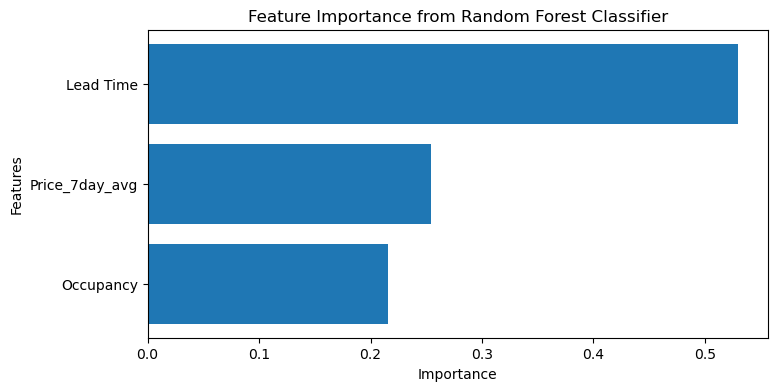

In [26]:
feature_importances = best_model.feature_importances_

importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 4))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest Classifier")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

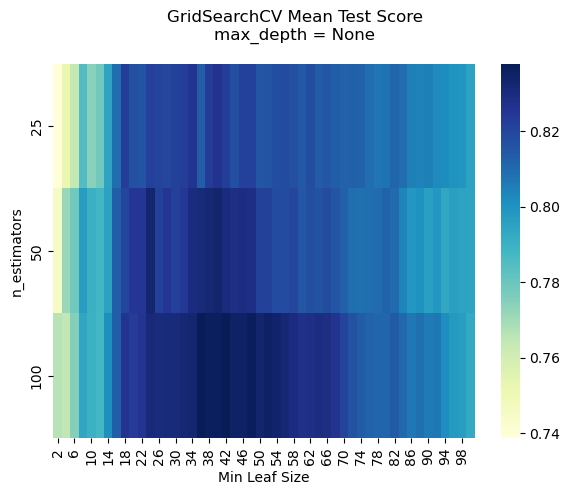

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `grid_search` is your GridSearchCV object
results = pd.DataFrame(grid_search.cv_results_)

# Unique max_depth values
max_depth_values = results['param_max_depth'].unique()

# Calculate the global min and max for mean_test_score to use in the color scale
vmin = results['mean_test_score'].min()
vmax = results['mean_test_score'].max()

# Check if max_depth has only one unique value
if len(max_depth_values) == 1:
    # Single plot case when max_depth is None
    fig, ax = plt.subplots(figsize=(6, 5))
    fig.suptitle(f"GridSearchCV Mean Test Score\nmax_depth = {max_depth_values[0]}")
    
    # Filter results for the unique max_depth
    scores_pivot = results.pivot(index="param_n_estimators", columns="param_min_samples_leaf", values="mean_test_score")
    
    # Create a single heatmap
    sns.heatmap(scores_pivot, fmt=".3f", cmap="YlGnBu", ax=ax, cbar=True, vmin=vmin, vmax=vmax)
    ax.set_xlabel("Min Leaf Size")
    ax.set_ylabel("n_estimators")

else:
    # Set up the subplots grid for multiple max_depth values
    fig, axes = plt.subplots(1, len(max_depth_values), figsize=(10, 4), sharey=True)
    fig.suptitle("GridSearchCV Mean Test Score", y=1.05)

    # Plot heatmaps for each max_depth
    for i, max_depth in enumerate(max_depth_values):
        # Filter results for the current max_depth
        subset = results[results['param_max_depth'] == max_depth]
        
        # Pivot the data for heatmap plotting
        scores_pivot = subset.pivot(index="param_n_estimators", columns="param_min_samples_leaf", values="mean_test_score")
        
        # Create heatmap on the corresponding subplot with consistent color scale
        sns.heatmap(scores_pivot, fmt=".3f", cmap="YlGnBu", ax=axes[i], cbar=(i == len(max_depth_values) - 1), vmin=vmin, vmax=vmax)
        axes[i].set_title(f"max_depth = {max_depth}")
        axes[i].set_xlabel("Min Leaf Size")
        axes[i].set_ylabel("n_estimators")

plt.tight_layout()
plt.show()


In [28]:
# # Make predictions on the same dataset
# predictions_rf_test = best_model.predict(X_test)
# predictions_rf_train = best_model.predict(X_train)

# # Evaluate the model
# accuracy_rf_train = accuracy_score(y_train, predictions_rf_train)
# accuracy_rf_test = accuracy_score(y_test, predictions_rf_test)
# print(f'Train Accuracy: {accuracy_rf_train}')
# print(f'Test Accuracy: {accuracy_rf_test}')

In [29]:
# Define parameter grid for min_samples_leaf
param_grid = {
    'min_child_weight': [1 * i for i in range(1, 100)],  
    'max_depth': [None], 
    'n_estimators': [25, 50, 100, 200, 400], 
    'learning_rate': [0.01,  0.1 ,0.3]

}

# # Initialize the RandomForestClassifier
# model = RandomForestClassifier(random_state=12)
# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier( random_state=12)

# Set up GridSearchCV with ROC AUC scoring
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    # scoring=make_scorer(accuracy_score, needs_proba=False),  
    scoring=make_scorer(roc_auc_score, needs_proba=True), 
    # scoring=make_scorer(average_precision_score, needs_proba=True),
    # cv=tscv,
    cv=custom_splits,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search_xgb.fit(X_train, y_train)

# Extract best parameters and score
best_params = grid_search_xgb.best_params_
best_score = grid_search_xgb.best_score_
print("Best Parameters:", best_params)
print(f"Best Cross-Validated Precision-Recall AUC Score: {best_score:0.4f}")

# Evaluate the model with best parameters on the test set
best_model_xgb = grid_search_xgb.best_estimator_
y_train_pred_xgb = best_model_xgb.predict(X_train)
y_test_pred_xgb = best_model_xgb.predict(X_test)

y_train_proba_xgb = best_model_xgb.predict_proba(X_train)[:, 1]
y_test_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1]

# Calculate and print test set accuracy and ROC AUC
train_accuracy = accuracy_score(y_train, y_train_pred_xgb)
test_accuracy = accuracy_score(y_test, y_test_pred_xgb)

train_roc_auc = roc_auc_score(y_train, y_train_proba_xgb)
test_roc_auc = roc_auc_score(y_test, y_test_proba_xgb)

train_pr_auc = average_precision_score(y_train, y_train_proba_xgb)
test_pr_auc = average_precision_score(y_test, y_test_proba_xgb)
print(f"Train Accuracy: {test_accuracy:0.4f}")
print(f"Test Accuracy: {test_accuracy:0.4f}\n")

print(f"Train ROC AUC Score: {train_roc_auc:0.4f}")
print(f"Test ROC AUC Score: {test_roc_auc:0.4f}\n")

print(f"Train Precision-Recall AUC Score: {train_pr_auc:0.4f}")
print(f"Test Precision-Recall AUC Score: {test_pr_auc:0.4f}")

Fitting 5 folds for each of 1485 candidates, totalling 7425 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': None, 'min_child_weight': 15, 'n_estimators': 400}
Best Cross-Validated Precision-Recall AUC Score: 0.8445
Train Accuracy: 0.8138
Test Accuracy: 0.8138

Train ROC AUC Score: 0.9624
Test ROC AUC Score: 0.9152

Train Precision-Recall AUC Score: 0.9500
Test Precision-Recall AUC Score: 0.8964


In [30]:
# # Make predictions on the same dataset
# predictions_xgb_test = best_model_xgb.predict(X_test)
# predictions_xgb_train = best_model_xgb.predict(X_train)

# y_train_proba_xgb = best_model_xgb.predict_proba(X_train)[:, 1]
# train_roc_auc = roc_auc_score(y_train, y_train_proba_xgb)
# train_pr_auc = average_precision_score(y_train, y_train_proba_xgb)

# print(f"Train Precision-Recall AUC Score: {train_pr_auc:0.4f}")
# print(f"Train ROC AUC Score: {train_roc_auc:0.4f}")
# print(f"Test Precision-Recall AUC Score: {test_pr_auc:0.4f}")

# # Evaluate the model
# accuracy_xgb_train = accuracy_score(y_train, predictions_xgb_train)
# accuracy_xgb_test = accuracy_score(y_test, predictions_xgb_test)
# print(f'Train Accuracy: {accuracy_xgb_train:0.4f}')
# print(f'Test Accuracy: {accuracy_xgb_test:0.4f}')

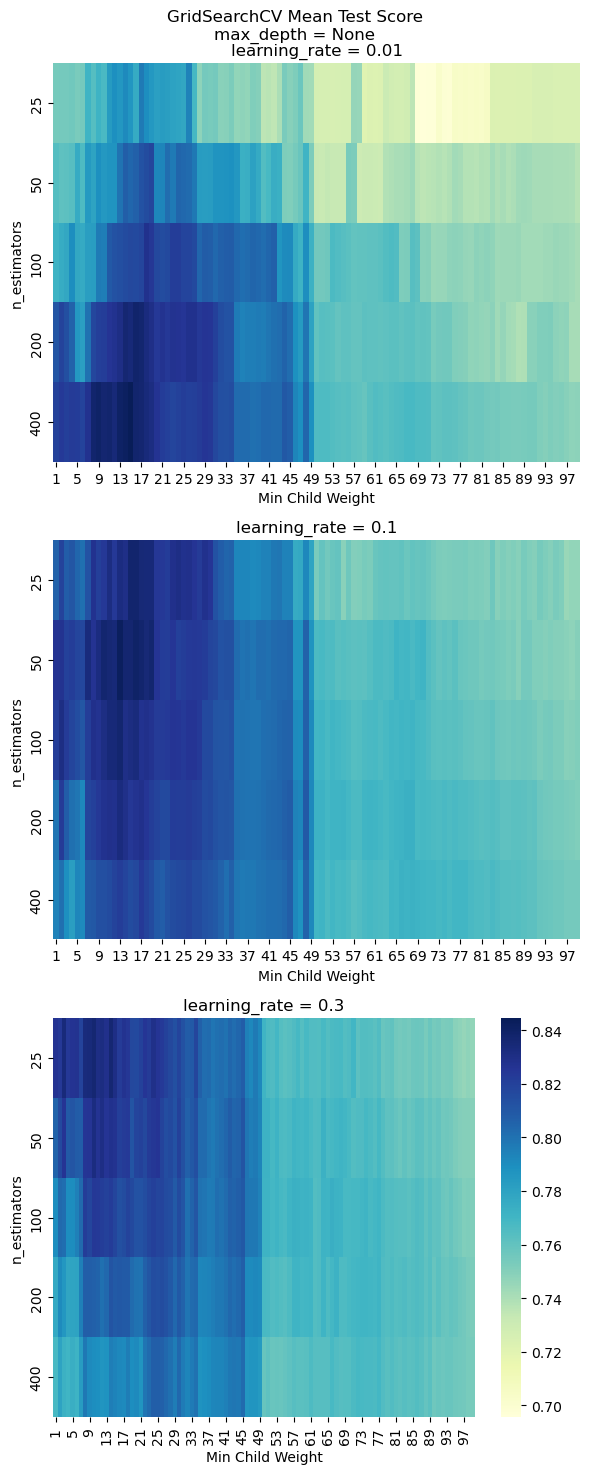

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `grid_search_xgb` is your GridSearchCV object
results = pd.DataFrame(grid_search_xgb.cv_results_)

# Unique values for learning_rate and max_depth
learning_rate_values = sorted(results['param_learning_rate'].unique())
max_depth_values = results['param_max_depth'].unique()

# Determine the global color scale limits
vmin = results['mean_test_score'].min()
vmax = results['mean_test_score'].max()

# Check if max_depth contains only None values
if all(pd.isnull(max_depth_values)):
    # Single column case when all max_depth values are None
    fig, axes = plt.subplots(len(learning_rate_values), 1, figsize=(6, 5 * len(learning_rate_values)), sharey=True)
    fig.suptitle(f"GridSearchCV Mean Test Score\nmax_depth = None")

    # Plot heatmaps for each learning_rate
    for i, learning_rate in enumerate(learning_rate_values):
        # Filter results for the current learning_rate
        subset = results[results['param_learning_rate'] == learning_rate]
        
        # Pivot the data for heatmap plotting
        scores_pivot = subset.pivot(index="param_n_estimators", columns="param_min_child_weight", values="mean_test_score")
        
        # Only plot if scores_pivot is not empty
        if not scores_pivot.empty:
            sns.heatmap(scores_pivot, fmt=".3f", cmap="YlGnBu", ax=axes[i], vmin=vmin, vmax=vmax, cbar=(i == len(learning_rate_values) - 1))
            axes[i].set_title(f"learning_rate = {learning_rate}")
            axes[i].set_xlabel("Min Child Weight")
            axes[i].set_ylabel("n_estimators")
        else:
            axes[i].axis('off')  # Hide the axis if there's no data to plot

else:
    # Set up the subplots grid for multiple max_depth values
    fig, axes = plt.subplots(len(learning_rate_values), len(max_depth_values), figsize=(12, 5 * len(learning_rate_values)), sharey=True)
    fig.suptitle("GridSearchCV Mean Test Score by Learning Rate and Max Depth", y=1.05)

    # Plot heatmaps for each combination of learning_rate and max_depth
    for i, learning_rate in enumerate(learning_rate_values):
        for j, max_depth in enumerate(max_depth_values):
            # Filter results for the current combination of learning_rate and max_depth
            subset = results[(results['param_learning_rate'] == learning_rate) & (results['param_max_depth'] == max_depth)]
            
            # Pivot the data for heatmap plotting
            scores_pivot = subset.pivot(index="param_n_estimators", columns="param_min_child_weight", values="mean_test_score")
            
            # Only plot if scores_pivot is not empty
            if not scores_pivot.empty:
                sns.heatmap(scores_pivot, fmt=".3f", cmap="YlGnBu", ax=axes[i, j], vmin=vmin, vmax=vmax,
                            cbar=(i == len(learning_rate_values) - 1 and j == len(max_depth_values) - 1))
                axes[i, j].set_title(f"learning_rate = {learning_rate}, max_depth = {max_depth}")
                axes[i, j].set_xlabel("Min Child Weight")
                axes[i, j].set_ylabel("n_estimators")
            else:
                axes[i, j].axis('off')  # Hide the axis if there's no data to plot

plt.tight_layout()
plt.show()


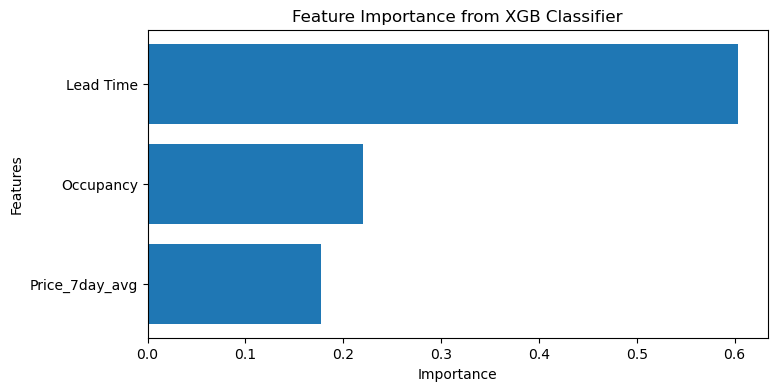

In [32]:
feature_importances_xgb = best_model_xgb.feature_importances_

importances_df_xgb = pd.DataFrame({'Feature': features, 'Importance': feature_importances_xgb})

# Sort features by importance
importances_df_xgb = importances_df_xgb.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 4))
plt.barh(importances_df_xgb['Feature'], importances_df_xgb['Importance'])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance from XGB Classifier")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [74]:
# import pandas as pd
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score


# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.5, 1, 2,4 ],
    'gamma': ['scale'],  # Since scale is performing best
    'kernel': ['linear']#, 'rbf', 'sigmoid'],
    # 'degree': [2, 3, 4]  # Only relevant for the polynomial kernel
}

# Initialize the SVM classifier with probability=True
model_svm = SVC(probability=True, random_state=12)

# Initialize GridSearchCV using custom splits
grid_search_svm = GridSearchCV(
    estimator=model_svm,
    param_grid=param_grid_svm,
    scoring=make_scorer(roc_auc_score, needs_proba=True),
    cv=custom_splits,  # Use custom splits based on unique dates
    n_jobs=-1,
    verbose=1
)

# Run the GridSearchCV
grid_search_svm.fit(X_train, y_train)

# Extract best parameters and score
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
print("Best Parameters (SVM):", best_params_svm)
print("Best Cross-Validated ROC AUC Score (SVM):", best_score_svm)

# Evaluate the best SVM model on the test set
best_model_svm = grid_search_svm.best_estimator_
y_test_pred_svm = best_model_svm.predict(X_test)
y_test_proba_svm = best_model_svm.predict_proba(X_test)[:, 1]

# Calculate and print test set accuracy and ROC AUC for SVM
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
test_roc_auc_svm = roc_auc_score(y_test, y_test_proba_svm)
print("Test Accuracy (SVM):", test_accuracy_svm)
print("Test ROC AUC Score (SVM):", test_roc_auc_svm)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters (SVM): {'C': 4, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validated ROC AUC Score (SVM): 0.8815299975579176
Test Accuracy (SVM): 0.7560521415270018
Test ROC AUC Score (SVM): 0.8881942707899196


In [77]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Train a LinearSVC model
linear_svc = LinearSVC(C=4)
calibrated_svc = CalibratedClassifierCV(base_estimator=linear_svc, method='sigmoid', cv=5)  # Platt Scaling
calibrated_svc.fit(X_train, y_train)

# Predict probabilities
probabilities = calibrated_svc.predict_proba(X_test)[:, 1]
probabilities


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.wa

array([0.80686488, 0.61547957, 0.77404171, 0.7864893 , 0.74916053,
       0.83813509, 0.7392177 , 0.2611425 , 0.77404171, 0.83813509,
       0.80686488, 0.83813509, 0.83813509, 0.7864893 , 0.83813509,
       0.74916053, 0.79810068, 0.72082671, 0.83813509, 0.79751353,
       0.84532914, 0.79810068, 0.71000461, 0.79810068, 0.34191878,
       0.30638903, 0.34191878, 0.80686488, 0.83813509, 0.62525968,
       0.4405071 , 0.7392177 , 0.2611425 , 0.72082671, 0.7553457 ,
       0.69239382, 0.69239382, 0.72082671, 0.68631223, 0.7864893 ,
       0.72613307, 0.77404171, 0.69239382, 0.79751353, 0.72082671,
       0.72613307, 0.7864893 , 0.84532914, 0.83813509, 0.72082671,
       0.7553457 , 0.77404171, 0.83813509, 0.83813509, 0.2611425 ,
       0.69239382, 0.62525968, 0.62525968, 0.30638903, 0.74916053,
       0.7864893 , 0.80686488, 0.71000461, 0.4405071 , 0.7553457 ,
       0.753549  , 0.71000461, 0.77404171, 0.753549  , 0.72082671,
       0.7392177 , 0.7553457 , 0.7864893 , 0.83813509, 0.75354

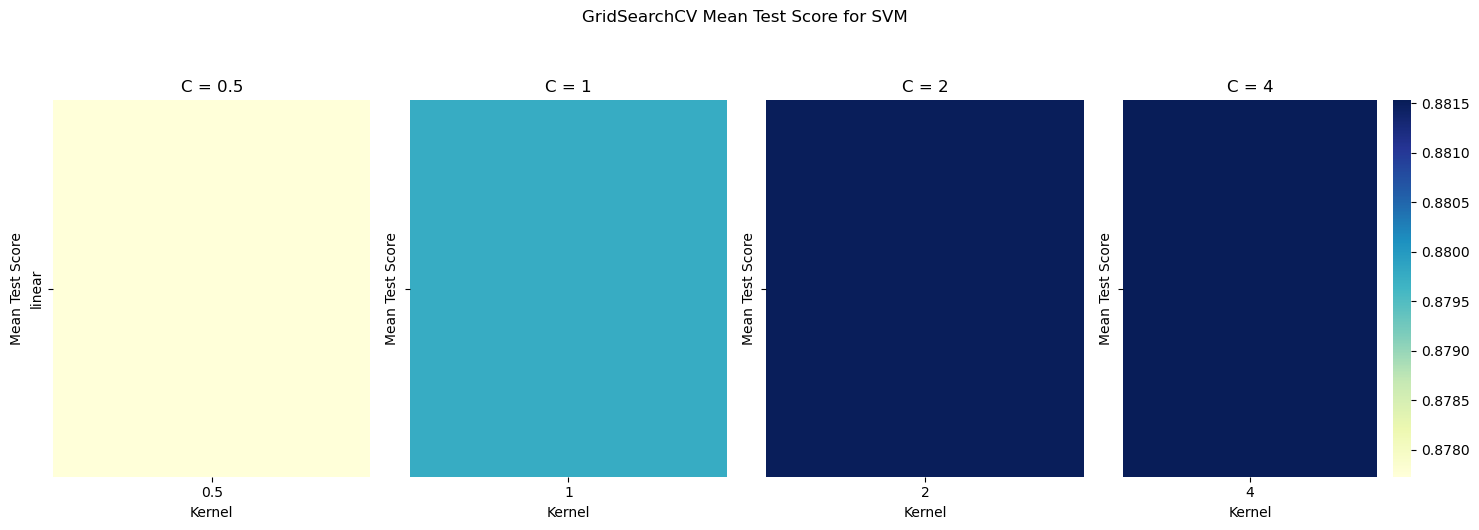

In [75]:


# Assuming `grid_search_svm` is your GridSearchCV object for the SVM
results_svm = pd.DataFrame(grid_search_svm.cv_results_)

# Unique values for C and gamma
C_values = results_svm['param_C'].unique()
gamma_values = results_svm['param_kernel'].unique()

# Calculate the global min and max for mean_test_score to use in the color scale
vmin = results_svm['mean_test_score'].min()
vmax = results_svm['mean_test_score'].max()

# Set up the subplots grid for each C value
fig, axes = plt.subplots(1, len(C_values), figsize=(15, 5), sharey=True)
fig.suptitle("GridSearchCV Mean Test Score for SVM", y=1.05)

# Plot heatmaps for each C value
for i, C in enumerate(C_values):
    # Filter results for the current C value
    subset = results_svm[results_svm['param_C'] == C]
    
    # Pivot the data for heatmap plotting
    scores_pivot = subset.pivot(index="param_kernel", columns="param_C", values="mean_test_score")
    
    # Create heatmap on the corresponding subplot with consistent color scale
    sns.heatmap(scores_pivot, fmt=".3f", cmap="YlGnBu", ax=axes[i], cbar=(i == len(C_values) - 1), vmin=vmin, vmax=vmax)
    axes[i].set_title(f"C = {C}")
    axes[i].set_xlabel("Kernel")
    axes[i].set_ylabel("Mean Test Score")

plt.tight_layout()
plt.show()


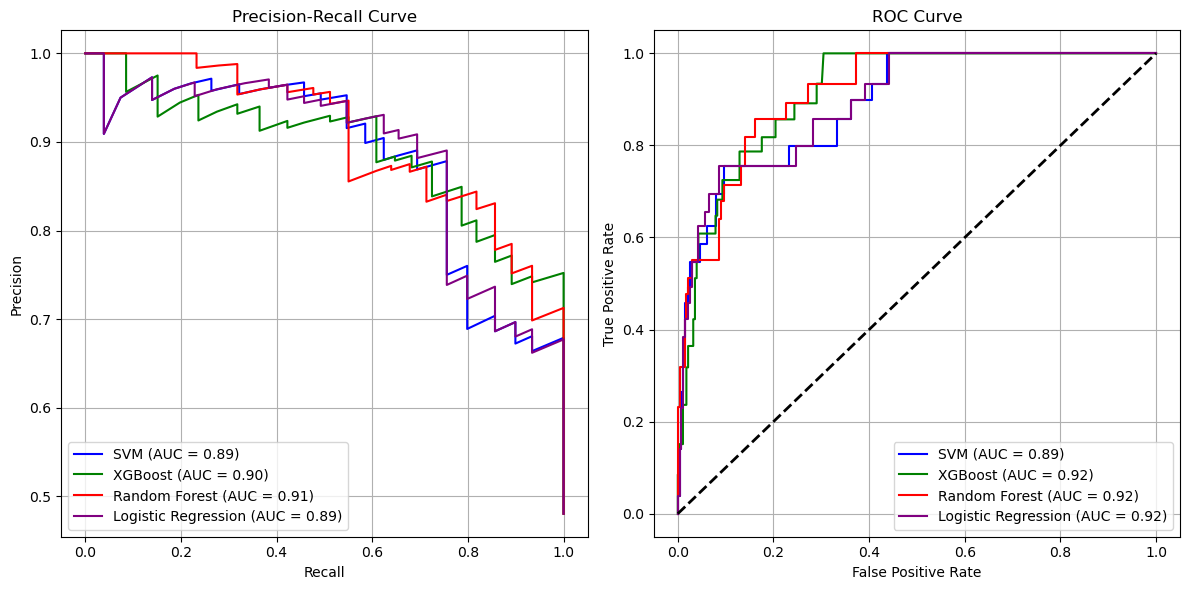

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score

# Calculate Precision-Recall and ROC metrics for each model
# SVM
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_test_proba_svm)
pr_auc_svm = average_precision_score(y_test, y_test_proba_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_test_proba_svm)
roc_auc_svm = roc_auc_score(y_test, y_test_proba_svm)

# XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_proba_xgb)
pr_auc_xgb = average_precision_score(y_test, y_test_proba_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_test_proba_xgb)

# Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_test_proba_rf)
pr_auc_rf = average_precision_score(y_test, y_test_proba_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_test_proba_rf)

# Logistic Regression
precision_log, recall_log, _ = precision_recall_curve(y_test, proba_log_test)
pr_auc_log = average_precision_score(y_test, proba_log_test)
fpr_log, tpr_log, _ = roc_curve(y_test, proba_log_test)
roc_auc_log = roc_auc_score(y_test, proba_log_test)


# Plot Precision-Recall curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(recall_svm, precision_svm, label=f'SVM (AUC = {pr_auc_svm:.2f})', color='blue')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUC = {pr_auc_xgb:.2f})', color='green')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {pr_auc_rf:.2f})', color='red')
plt.plot(recall_log, precision_log, label=f'Logistic Regression (AUC = {pr_auc_log:.2f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()

# Plot ROC curves
plt.subplot(1, 2, 2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', color='green')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', color='red')
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_rf:.2f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()

plt.tight_layout()
plt.show()


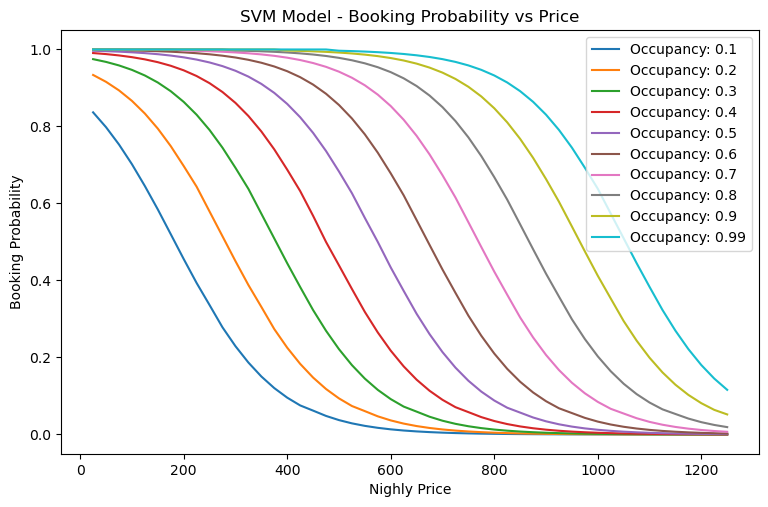

In [82]:
occupanccies = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

plt.figure(figsize=(9, 5.5))
for occupancy in occupanccies:
    svm_sensitivity_X =  pd.DataFrame({
                                'Occupancy':[occupancy for i in range(1,51)],
                                'Lead Time': [7 for i in range(1,51)],
                                'Price_7day_avg':[25*i for i in range(1,51)]
                                #   'Price_slope14': [-30 for i in range(8)] + [30 for i in range(8)]
                                })

    sensitivity_xgb_pred = best_model_xgb.predict_proba(svm_sensitivity_X)[:,1] 
    sensitivity_rf_pred = best_model.predict_proba(svm_sensitivity_X)[:,1] 
    sensitivity_log_pred = model_log.predict_proba(svm_sensitivity_X)[:,1]
    sensitivity_svm_pred = best_model_svm.predict_proba(svm_sensitivity_X)[:,1]
    # sensitivity_svm_pred = calibrated_svc.predict_proba(svm_sensitivity_X)[:,1]
    sensitivity_gam_pred = gam.predict_proba(svm_sensitivity_X)
    sensitivity_NB_pred = model_NB.predict_proba(svm_sensitivity_X)[:,1]

    sensitivity_df = svm_sensitivity_X.copy()

    sensitivity_df['RF Booking Probability'] = pd.Series(sensitivity_rf_pred)
    sensitivity_df['XGB Booking Probability'] = pd.Series(sensitivity_xgb_pred)
    sensitivity_df['SVM Booking Probability'] = pd.Series(sensitivity_svm_pred)
    sensitivity_df['Logistic Reg Booking Probability'] = pd.Series(sensitivity_log_pred)
    sensitivity_df['GAM Booking Probability'] = pd.Series(sensitivity_gam_pred)
    sensitivity_df['Naive Bayes Booking Probability'] = pd.Series(sensitivity_NB_pred)

    sensitivity_df['SVM_Nightly_Revenue_Expected_Value'] =  sensitivity_df['SVM Booking Probability']* svm_sensitivity_X['Price_7day_avg']
    sensitivity_df['GAM_Nightly_Revenue_Expected_Value'] =  sensitivity_df['GAM Booking Probability']* svm_sensitivity_X['Price_7day_avg']
    sensitivity_df['NB_Nightly_Revenue_Expected_Value'] =  sensitivity_df['Naive Bayes Booking Probability']* svm_sensitivity_X['Price_7day_avg']

    plt.plot(sensitivity_df['Price_7day_avg'], sensitivity_df['SVM Booking Probability'], label=f'Occupancy: {occupancy}')
    # plt.yscale('log')
plt.title('SVM Model - Booking Probability vs Price')
plt.xlabel('Nighly Price')
plt.ylabel('Booking Probability')
plt.legend()
plt.show()

    

C:\Users\rgiblet\AppData\Local\Temp\ipykernel_24656\3220276559.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  optimal_pricing = pd.concat([optimal_pricing, pd.DataFrame({'Occupancy':[occupancy],


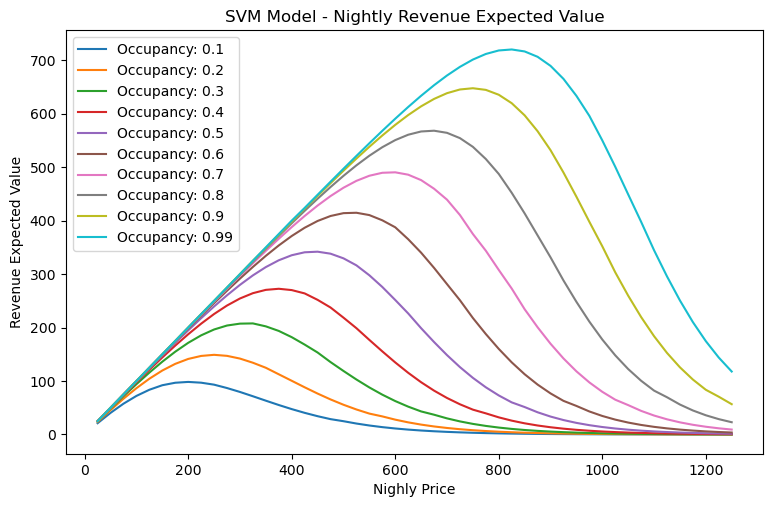

In [ ]:
occupancies = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

optimal_pricing = pd.DataFrame(columns=['Occupancy','Optimal Nighly Price', 'Booking Probability','Revenue Expected Value'])

plt.figure(figsize=(9, 5.5))
for occupancy in occupancies:
    svm_sensitivity_X =  pd.DataFrame({
                                'Occupancy':[occupancy for i in range(1,51)],
                                'Lead Time': [7 for i in range(1,51)],
                                'Price_7day_avg':[25*i for i in range(1,51)]
                                })
   
    sensitivity_xgb_pred = best_model_xgb.predict_proba(svm_sensitivity_X)[:,1] 
    sensitivity_rf_pred = best_model.predict_proba(svm_sensitivity_X)[:,1] 
    sensitivity_log_pred = model_log.predict_proba(svm_sensitivity_X)[:,1]
    sensitivity_svm_pred = best_model_svm.predict_proba(svm_sensitivity_X)[:,1]
    sensitivity_gam_pred = gam.predict_proba(svm_sensitivity_X)
    sensitivity_NB_pred = model_NB.predict_proba(svm_sensitivity_X)[:,1]

    sensitivity_df = sensitivity_X.copy()

    sensitivity_df['RF Booking Probability'] = pd.Series(sensitivity_rf_pred)
    sensitivity_df['XGB Booking Probability'] = pd.Series(sensitivity_xgb_pred)
    sensitivity_df['SVM Booking Probability'] = pd.Series(sensitivity_svm_pred)
    sensitivity_df['Logistic Reg Booking Probability'] = pd.Series(sensitivity_log_pred)
    sensitivity_df['GAM Booking Probability'] = pd.Series(sensitivity_gam_pred)
    sensitivity_df['Naive Bayes Booking Probability'] = pd.Series(sensitivity_NB_pred)

    sensitivity_df['Log_Reg_Nightly_Revenue_Expected_Value'] =  sensitivity_df['Logistic Reg Booking Probability']* svm_sensitivity_X['Price_7day_avg']
    sensitivity_df['SVM_Nightly_Revenue_Expected_Value'] =  sensitivity_df['SVM Booking Probability']* svm_sensitivity_X['Price_7day_avg']
    sensitivity_df['GAM_Nightly_Revenue_Expected_Value'] =  sensitivity_df['GAM Booking Probability']* svm_sensitivity_X['Price_7day_avg']
    sensitivity_df['NB_Nightly_Revenue_Expected_Value'] =  sensitivity_df['Naive Bayes Booking Probability']* svm_sensitivity_X['Price_7day_avg']

    optimal_index = np.where(sensitivity_df['SVM_Nightly_Revenue_Expected_Value'] == sensitivity_df['SVM_Nightly_Revenue_Expected_Value'].max())[0][0]
    best_price = svm_sensitivity_X.iloc[optimal_index]['Price_7day_avg']
    best_prob = sensitivity_df.iloc[optimal_index]['SVM Booking Probability']

    optimal_pricing = pd.concat([optimal_pricing, pd.DataFrame({'Occupancy':[occupancy],
            'Optimal Nighly Price': [best_price], 
            'Booking Probability' : [best_prob],
            'Revenue Expected Value':[sensitivity_df['SVM_Nightly_Revenue_Expected_Value'].max()]})])
    
    plt.plot(sensitivity_df['Price_7day_avg'], sensitivity_df['SVM_Nightly_Revenue_Expected_Value'], label=f'Occupancy: {occupancy}')
    # plt.yscale('log')
plt.title('SVM Model - Nightly Revenue Expected Value')
plt.xlabel('Nighly Price')
plt.ylabel('Revenue Expected Value')
plt.legend()
plt.show()

In [63]:
optimal_pricing

,Occupancy,Optimal Nighly Price,Booking Probability,Revenue Expected Value
0,0.10,200.0,0.491626,98.325127
0,0.20,250.0,0.596033,149.008165
0,0.30,325.0,0.639266,207.761331
0,0.40,375.0,0.726784,272.544145
0,0.50,450.0,0.759773,341.898040
0,0.60,525.0,0.789943,414.720129
0,0.70,600.0,0.817255,490.353226
0,0.80,675.0,0.841744,568.177304
0,0.90,750.0,0.863506,647.629211
0,0.99,825.0,0.872885,720.130392


In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd

# Define thresholds to test
thresholds = np.arange(0.05, 1.0, 0.05)

# Store results for precision, recall, FPR, and F1 at each threshold
results = []

for threshold in thresholds:
    # Classify as positive if the probability is greater than the threshold
    y_test_pred_custom = (y_test_proba_svm >= threshold).astype(int)  # Replace with desired model probabilities

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_custom).ravel()
    
    # Calculate Precision, Recall, False Positive Rate (FPR), and F1 Score
    precision = precision_score(y_test, y_test_pred_custom)
    recall = recall_score(y_test, y_test_pred_custom)
    fpr = fp / (fp + tn)  # False Positive Rate
    f1 = f1_score(y_test, y_test_pred_custom)

    # Append results to list
    results.append((threshold, precision, recall, fpr, f1))

# Create DataFrame with results
results_df = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "False Positive Rate", "F1 Score"])
print(results_df)


    Threshold  Precision    Recall  False Positive Rate  F1 Score
0        0.05   0.565789  1.000000             0.709677  0.722689
1        0.10   0.614286  1.000000             0.580645  0.761062
2        0.15   0.649874  1.000000             0.498208  0.787786
3        0.20   0.677165  1.000000             0.440860  0.807512
4        0.25   0.676966  0.934109             0.412186  0.785016
5        0.30   0.686391  0.899225             0.379928  0.778523
6        0.35   0.701587  0.856589             0.336918  0.771379
7        0.40   0.700680  0.798450             0.315412  0.746377
8        0.45   0.720280  0.798450             0.286738  0.757353
9        0.50   0.733096  0.798450             0.268817  0.764378
10       0.55   0.752896  0.755814             0.229391  0.754352
11       0.60   0.773810  0.755814             0.204301  0.764706
12       0.65   0.805785  0.755814             0.168459  0.780000
13       0.70   0.862832  0.755814             0.111111  0.805785
14       0